In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs 
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

 # please re-start kernel if these packages are installed for the first time

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
from phantasy import caget, fetch_data

In [3]:
import objFuncs
from objFuncs.util import read_BPMoverview_snapshot
from objFuncs import maximize_FC
from objFuncs.util import plot_obj_history
from pyBO import pyBO

== default machineIOs are...
   _test : False
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.2
   _fetch_data_time_span : 1
   _return_obj_var : False
   _check_chopper_blocking : True


In [7]:
budget = 16
n_init = 8

# check objFuncs machineIO, source and beam  

In [4]:
objFuncs._global_machineIO._test = False
objFuncs._global_machineIO._fetch_data_time_span = 5.05
objFuncs._global_machineIO._ensure_set_timewait_after_ramp = 0.5
# objFuncs._global_machineIO.view()

In [5]:
SCS = caget("ACS_DIAG:DEST:ACTIVE_ION_SOURCE")
ion = caget("FE_ISRC"+str(SCS)+":BEAM:ELMT_BOOK")
Q = caget("FE_ISRC"+str(SCS)+":BEAM:Q_BOOK")
A = caget("FE_ISRC"+str(SCS)+":BEAM:A_BOOK")
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print('SCS'+str(SCS), ion, 'A/Q=',AQ)

SCS2 16O6 A/Q= 2.6666666666666665


In [ ]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

In [ ]:
now0str = datetime.datetime.now().strftime('%Y%m%d_%H%M')
fname = now0str+'['+ion+']'+nb_name.strip('.ipynb')
fname

# preprare objective

In [8]:
decision_CSETs=['FE_MEBT:RFC_D1066:PHA_CSET'   , 'FE_MEBT:RFC_D1107:PHA_CSET'   ]
decision_RDs = ['FE_MEBT:RFC_D1066:PHA_RD_CAVS', 'FE_MEBT:RFC_D1107:PHA_RD_CAVS']
decision_tols = [0.05, 0.05]
ave,_ = fetch_data(decision_CSETs,0.1)

decision_min = ave - 1.5
decision_max = ave + 1.5

print(decision_min)
print(decision_max)

[11.83695362 28.54395037]
[14.83695362 31.54395037]


In [10]:
BPM_snapshot_fname = '20230525_16O6_reference/20230527_1146_16O6_140p6MeVu_LS3_completed.bpm'
objective_goal = read_BPMoverview_snapshot(BPM_snapshot_fname,Dnum_from=1100,Dnum_to=1477)
objective_goal

{'FE_MEBT:BPM_D1111:PHASE_RD': 14.235748555774851,
 'LS1_CA01:BPM_D1129:PHASE_RD': -29.41176310520732,
 'LS1_CA01:BPM_D1144:PHASE_RD': -51.18718100433834,
 'LS1_WA01:BPM_D1155:PHASE_RD': 25.65933443334713,
 'LS1_CA02:BPM_D1163:PHASE_RD': -15.143883764475396,
 'LS1_CA02:BPM_D1177:PHASE_RD': -24.03296614297258,
 'LS1_WA02:BPM_D1188:PHASE_RD': 5.414507113780229,
 'LS1_CA03:BPM_D1196:PHASE_RD': -53.842993465276244,
 'LS1_CA03:BPM_D1211:PHASE_RD': 14.066589842532101,
 'LS1_WA03:BPM_D1222:PHASE_RD': -1.8243770014211829,
 'LS1_CB01:BPM_D1231:PHASE_RD': -54.29361046759759,
 'LS1_CB01:BPM_D1251:PHASE_RD': -27.999045138719463,
 'LS1_CB01:BPM_D1271:PHASE_RD': 21.69344568221685,
 'LS1_WB01:BPM_D1286:PHASE_RD': -61.76197472232553,
 'LS1_CB02:BPM_D1295:PHASE_RD': -85.45019687106681,
 'LS1_CB02:BPM_D1315:PHASE_RD': -3.1775748249505518,
 'LS1_CB02:BPM_D1335:PHASE_RD': -31.47751189873538,
 'LS1_WB02:BPM_D1350:PHASE_RD': -73.34661664183491,
 'LS1_CB03:BPM_D1359:PHASE_RD': -34.4788500429661,
 'LS1_CB03:B

In [24]:
# objective_goal = {
#     'FE_MEBT:BPM_D1056:XPOS_RD': -1.0940998392596917,
#     'FE_MEBT:BPM_D1056:YPOS_RD': -0.019491418399209,
#     'FE_MEBT:BPM_D1056:PHASE_RD': 76.90770742747644,
#     'FE_MEBT:BPM_D1056:MAG_RD': {'more than': None},
#     'FE_MEBT:BPM_D1072:XPOS_RD': 0.032766532755004,
#     'FE_MEBT:BPM_D1072:YPOS_RD': -0.021836802378343904,
#     'FE_MEBT:BPM_D1072:PHASE_RD': -26.787524830576125,
#     'FE_MEBT:BPM_D1072:MAG_RD': {'more than': None},
#     'FE_MEBT:BPM_D1094:XPOS_RD': 0.10449399372712796,
#     'FE_MEBT:BPM_D1094:YPOS_RD': -0.15601053214377406,
#     'FE_MEBT:BPM_D1094:PHASE_RD': -16.359215751371813,
#     'FE_MEBT:BPM_D1094:MAG_RD': {'more than': None},
#     'FE_MEBT:BCM_D1055:AVGPK_RD/FE_LEBT:BCM_D0989:AVGPK_RD': {'more than': 0.98},
#     'FE_MEBT:FC_D1102:PKAVG_RD': {'more than': 0.8*FC998} #0.8*FC814
# }

In [25]:
objective_norm = {k:1. for k in objective_goal.keys()}
objective_weight = {k:1. for k in objective_goal.keys()}

In [26]:
obj = objFuncs.objFuncGoals(
    decision_CSETs=decision_CSETs,
    decision_RDs = decision_RDs,
    decision_min = decision_min,
    decision_max = decision_max,
    decision_tols = decision_tols,
    objective_goal = objective_goal,
    objective_weight = objective_weight,
    objective_norm = objective_norm,
    apply_bilog = True,
    history_logging_fname = fname,
    history_logging_frequency = np.inf,
)

== decision sets ==


{'FE_MEBT:RFC_D1066:PHA_CSET': 13.617363426323267,
 'FE_MEBT:RFC_D1107:PHA_CSET': 30.10584976360976}

== objective_goal ==


OrderedDict([('FE_MEBT:BPM_D1111:PHASE_RD', 14.235748555774851),
             ('LS1_CA01:BPM_D1129:PHASE_RD', -29.41176310520732),
             ('LS1_CA01:BPM_D1144:PHASE_RD', -51.18718100433834),
             ('LS1_WA01:BPM_D1155:PHASE_RD', 25.65933443334713),
             ('LS1_CA02:BPM_D1163:PHASE_RD', -15.143883764475396),
             ('LS1_CA02:BPM_D1177:PHASE_RD', -24.03296614297258),
             ('LS1_WA02:BPM_D1188:PHASE_RD', 5.414507113780229),
             ('LS1_CA03:BPM_D1196:PHASE_RD', -53.842993465276244),
             ('LS1_CA03:BPM_D1211:PHASE_RD', 14.066589842532101),
             ('LS1_WA03:BPM_D1222:PHASE_RD', -1.8243770014211829),
             ('LS1_CB01:BPM_D1231:PHASE_RD', -54.29361046759759),
             ('LS1_CB01:BPM_D1251:PHASE_RD', -27.999045138719463),
             ('LS1_CB01:BPM_D1271:PHASE_RD', 21.69344568221685),
             ('LS1_WB01:BPM_D1286:PHASE_RD', -61.76197472232553),
             ('LS1_CB02:BPM_D1295:PHASE_RD', -85.45019687106681),
          

== objective_norm ==


OrderedDict([('FE_MEBT:BPM_D1111:PHASE_RD', 1.0),
             ('LS1_CA01:BPM_D1129:PHASE_RD', 1.0),
             ('LS1_CA01:BPM_D1144:PHASE_RD', 1.0),
             ('LS1_WA01:BPM_D1155:PHASE_RD', 1.0),
             ('LS1_CA02:BPM_D1163:PHASE_RD', 1.0),
             ('LS1_CA02:BPM_D1177:PHASE_RD', 1.0),
             ('LS1_WA02:BPM_D1188:PHASE_RD', 1.0),
             ('LS1_CA03:BPM_D1196:PHASE_RD', 1.0),
             ('LS1_CA03:BPM_D1211:PHASE_RD', 1.0),
             ('LS1_WA03:BPM_D1222:PHASE_RD', 1.0),
             ('LS1_CB01:BPM_D1231:PHASE_RD', 1.0),
             ('LS1_CB01:BPM_D1251:PHASE_RD', 1.0),
             ('LS1_CB01:BPM_D1271:PHASE_RD', 1.0),
             ('LS1_WB01:BPM_D1286:PHASE_RD', 1.0),
             ('LS1_CB02:BPM_D1295:PHASE_RD', 1.0),
             ('LS1_CB02:BPM_D1315:PHASE_RD', 1.0),
             ('LS1_CB02:BPM_D1335:PHASE_RD', 1.0),
             ('LS1_WB02:BPM_D1350:PHASE_RD', 1.0),
             ('LS1_CB03:BPM_D1359:PHASE_RD', 1.0),
             ('LS1_CB03:BPM_D137

== objective_weight ==


OrderedDict([('FE_MEBT:BPM_D1111:PHASE_RD', 0.045454545454545456),
             ('LS1_CA01:BPM_D1129:PHASE_RD', 0.045454545454545456),
             ('LS1_CA01:BPM_D1144:PHASE_RD', 0.045454545454545456),
             ('LS1_WA01:BPM_D1155:PHASE_RD', 0.045454545454545456),
             ('LS1_CA02:BPM_D1163:PHASE_RD', 0.045454545454545456),
             ('LS1_CA02:BPM_D1177:PHASE_RD', 0.045454545454545456),
             ('LS1_WA02:BPM_D1188:PHASE_RD', 0.045454545454545456),
             ('LS1_CA03:BPM_D1196:PHASE_RD', 0.045454545454545456),
             ('LS1_CA03:BPM_D1211:PHASE_RD', 0.045454545454545456),
             ('LS1_WA03:BPM_D1222:PHASE_RD', 0.045454545454545456),
             ('LS1_CB01:BPM_D1231:PHASE_RD', 0.045454545454545456),
             ('LS1_CB01:BPM_D1251:PHASE_RD', 0.045454545454545456),
             ('LS1_CB01:BPM_D1271:PHASE_RD', 0.045454545454545456),
             ('LS1_WB01:BPM_D1286:PHASE_RD', 0.045454545454545456),
             ('LS1_CB02:BPM_D1295:PHASE_RD', 0.04

== etc ==
objective_p_order:  2
apply_bilog:  True


 # Prepare plot callbacks

In [27]:
# define what to plot
plot_CSETs = plot_obj_history(
                obj.history['decision_CSETs'],
                title = 'decision_CSETs',
                inline = True,
                )
plot_RDs = plot_obj_history(
                obj.history['objective_RDs'],
                title = 'objective_RDs',
                inline = True,
                )
plot_objs = plot_obj_history(
            obj.history['objectives'],
            title = 'objectives',
            inline = True,
            add_y_data = obj.history['objectives']['total'],
            add_y_label = 'total obj'
            )
callbacks = [plot_CSETs,plot_RDs,plot_objs]

# evaluate objective and plot
def obj_callbacks(x):
    return obj(x,callbacks=callbacks)

# Run BO

### run BO until budget exhaust

scipy version mismatch. 'scipy.stat.qmc' is not imported. Using custom halton seqeunce instead


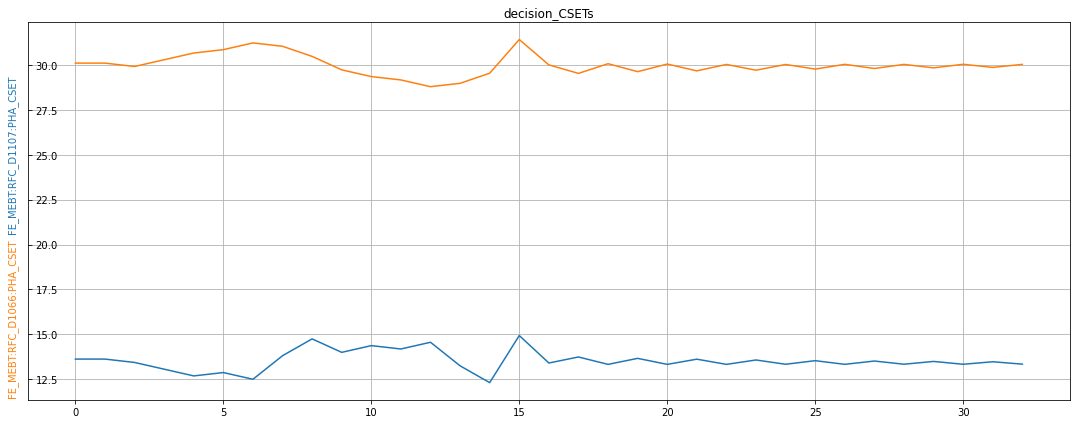

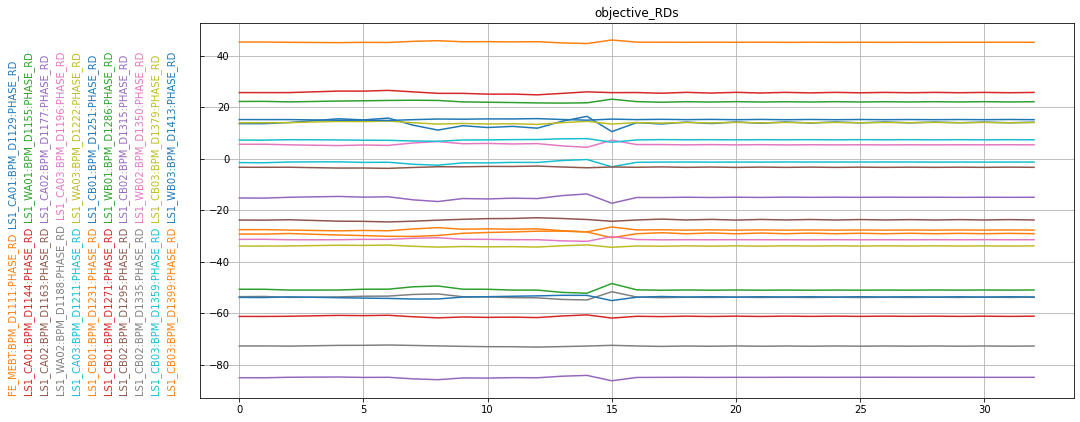

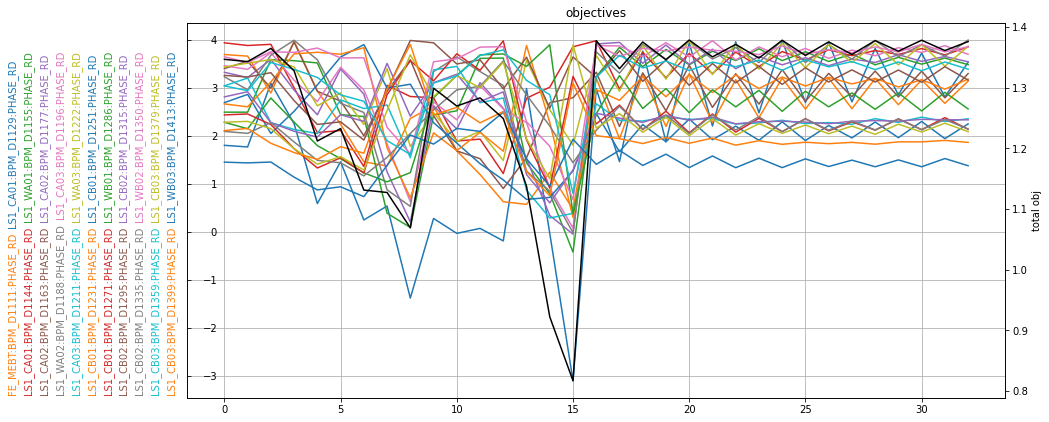

[████████████████████████████████████████] 100%/100%



In [28]:
# run optimizer
bo, X_pending, Y_pending_future = pyBO.runBO(
                                    obj_callbacks,  
                                    bounds=obj.decision_bounds,
                                    n_init=n_init,
                                    budget = budget,
                                    batch_size=1,
#                                     timeout = 2+objFuncs._global_machineIO._fetch_data_time_span,
                                    path="./log/",
                                    tag=fname+'_pyBO_history',
                                    write_log = False)
for f in callbacks:
    f.close()

In [29]:
now1 = datetime.datetime.now()
now1str = str(now1)[:str(now1).rfind(':')].replace(' ','_').replace(':','').replace('-','')
time_delta = now1 - now0
print("time took:",str(time_delta.total_seconds()/60)[:4],'min')

time took: 3.75 min


In [30]:
# # uncomment and run if more iteration needed
# X_pending, Y_pending_future= bo.loop( 
#                                 n_loop=4,  # number of additional optimization interation
#                                 func_obj = obj_callbacks,
#                                 X_pending = X_pending, 
#                                 Y_pending_future = Y_pending_future,
#                                 batch_size = 1,
#                                 write_log = False,
#                                 )
# for f in callbacks:
#     f.close()

### Fine Tune near current best

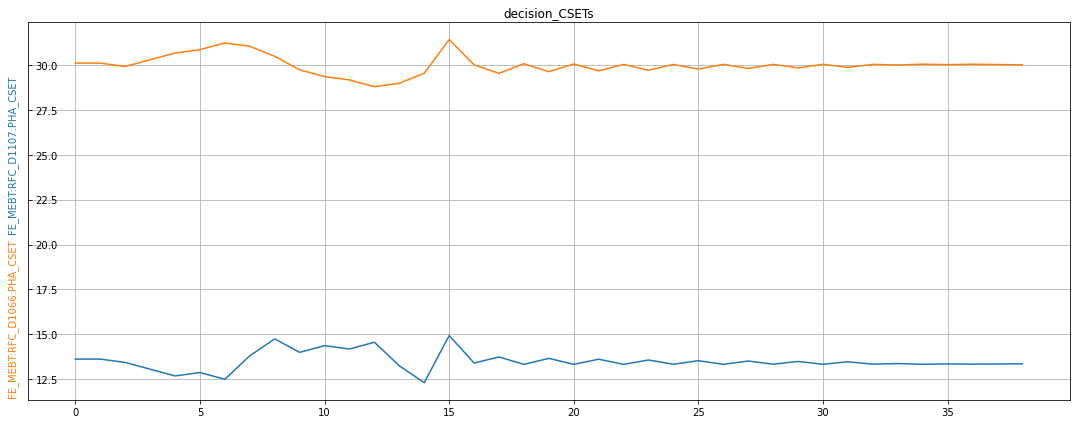

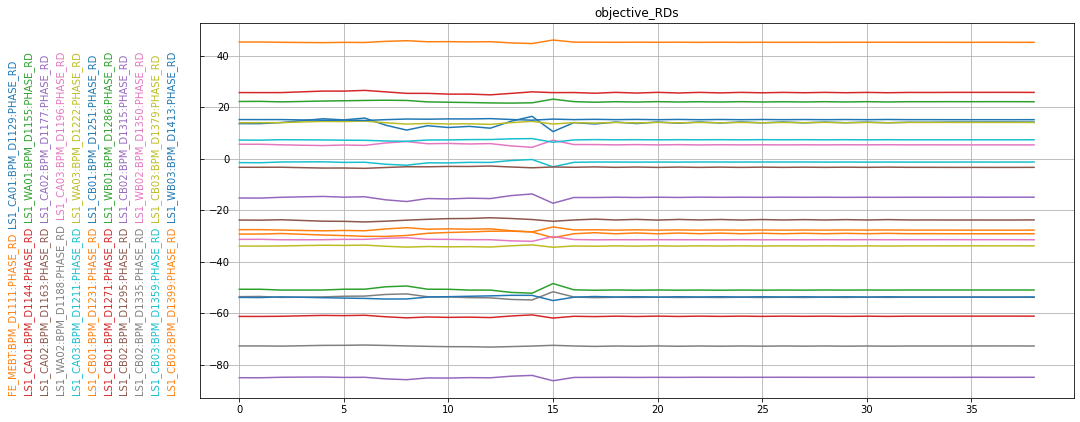

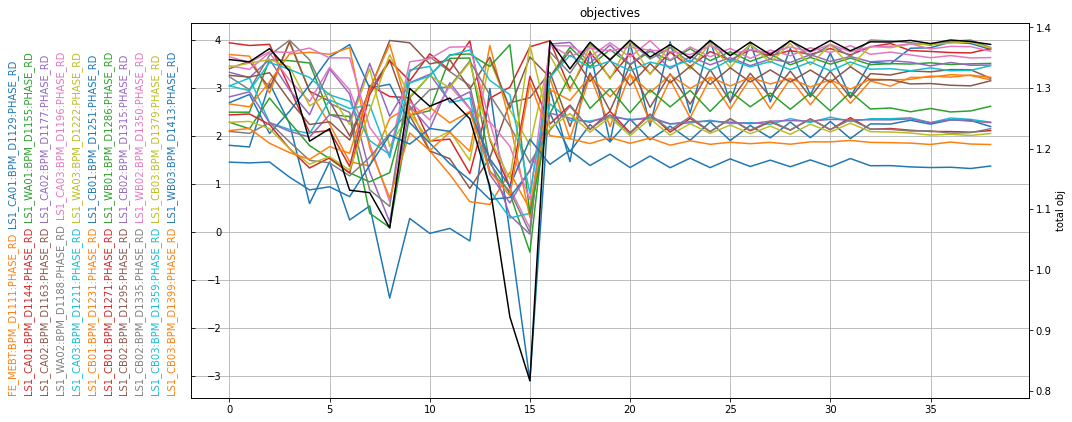

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%



In [31]:
# local optimization near the best_solution
for i in range(3):
    x_best,y_best = bo.best_sofar()
    bounds_best = np.array([(x-0.1*AQ,x+0.1*AQ) for x in x_best])   
    acquisition_func_args = {'beta':0.1}

    X_pending, Y_pending_future= bo.loop( 
                                    n_loop=2,  # number of additional optimization interation
                                    func_obj = obj_callbacks,
                                    bounds = bounds_best,
                                    acquisition_func_args = acquisition_func_args,
                                    X_pending = X_pending, 
                                    Y_pending_future = Y_pending_future,
                                    batch_size = 1,
                                    write_log = False,
                                    )
for f in callbacks:
    f.close()

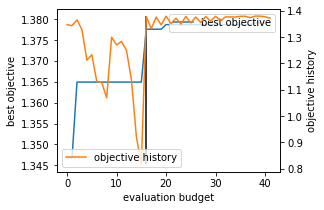

In [32]:
ax = bo.plot_obj_history()
ax.vlines(n_init,*ax.get_ylim(),color='k')

### set to best solution 

In [33]:
x_best,y_best_old = bo.best_sofar()
y_best_new = obj(x_best)
print(x_best,y_best_old[0],y_best_new)   # check if best solution objective value is consistent

[13.33695362 30.04395037] 1.3790804014748732 1.3760749470370746


In [34]:
obj.write_log(fname=os.path.join('./log',fname))

# change objective goal/norm/weights. 
##### Note that if an objective weight were zero previously, that objective cannot be added.
objFunc does not read nor record data corresponding to the zero weight

In [35]:
# objective_weight = { 
#     'FE_MEBT:BPM_D1056:XPOS_RD' : 0.5,     
#     'FE_MEBT:BPM_D1056:YPOS_RD' : 0.5,     
#     'FE_MEBT:BPM_D1056:PHASE_RD': 1., 
#     'FE_MEBT:BPM_D1056:MAG_RD'  : 0., 
#     'FE_MEBT:BPM_D1072:XPOS_RD' : 0.,     
#     'FE_MEBT:BPM_D1072:YPOS_RD' : 0.,     
#     'FE_MEBT:BPM_D1072:PHASE_RD': 0., 
#     'FE_MEBT:BPM_D1072:MAG_RD'  : 0., 
#     'FE_MEBT:BPM_D1094:XPOS_RD' : 0.0,     
#     'FE_MEBT:BPM_D1094:YPOS_RD' : 0.0,     
#     'FE_MEBT:BPM_D1094:PHASE_RD': 0.0,
#     'FE_MEBT:BPM_D1094:MAG_RD'  : 0,
#     'FE_MEBT:BCM_D1055:AVGPK_RD/FE_LEBT:BCM_D0989:AVGPK_RD': 3,
#     'FE_MEBT:FC_D1102:PKAVG_RD': 3.,
#     }

# obj.update_objective(objective_weight=objective_weight)

# x = np.array(obj.history['decision_CSETs']['values'][:-1])
# y = np.array(obj.history['objectives']['total'])[:-1,None]
# bo.update_model(x=x,y=y)

# x_best,y_best = bo.best_sofar()
# print(x_best, y_best)

In [36]:
# acquisition_func_args = {'beta':9.}
# X_pending, Y_pending_future= bo.loop( 
#                             n_loop=10,  # number of additional optimization interation
#                             func_obj = obj_callbacks,
#                             bounds = obj.decision_bounds,
#                             acquisition_func_args = acquisition_func_args,
#                             X_pending = X_pending, 
#                             Y_pending_future = Y_pending_future,
#                             batch_size = 1,
#                             write_log = False,
#                             )
# for f in callbacks:
#     f.close()

In [37]:
# # local optimization near the best_solution
# x_best,y_best = bo.best_sofar()
# bounds_best = np.array([(x-0.1*AQ,x+0.1*AQ) for x in x_best])   
# acquisition_func_args = {'beta':0.4}

# X_pending, Y_pending_future= bo.loop( 
#                                 n_loop=4,  # number of additional optimization interation
#                                 func_obj = obj_callbacks,
#                                 bounds = bounds_best,
#                                 acquisition_func_args = acquisition_func_args,
#                                 X_pending = X_pending, 
#                                 Y_pending_future = Y_pending_future,
#                                 batch_size = 1,
#                                 write_log = False,
#                                 )
# for f in callbacks:
#     f.close()

In [38]:
# ax = bo.plot_obj_history()
# ax.vlines(n_init,*ax.get_ylim(),color='k')

In [39]:
# # set to best solution 
# x_best,y_best_old = bo.best_sofar()
# y_best_new = obj(x_best)
# print(x_best,y_best_old[0],y_best_new)   # check if best solution objective value is consistent

In [40]:
# obj.write_log(fname=os.path.join('./log',fname))

# Visualize Surrogate model

In [41]:
# fixed_values_for_each_dim = {2:x_best[2],3:x_best[3]}  # fix values to visualize high dim surrogate model
fixed_values_for_each_dim = None                         # do not fix values but project maximum. Can take long time to plot
batch_size = 1

[████████████████████████████████████████] 100%/100%

time took:  0.10499526001513004


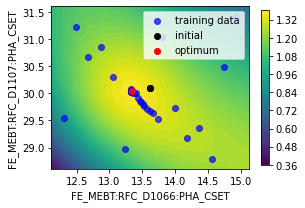

In [42]:
# plot surrogate mean model of the last epoch. Can take long time for decision dim >= 4

t0 = time.monotonic()
from math import ceil
nplot = int(0.5*len(obj.decision_CSETs))
nrow = ceil(0.5*nplot)
fig,ax = plt.subplots(nrow,2,figsize=(8,3*nrow))
for i in range(nrow):
    for j in range(2):
        n = 2*i+j
        if nrow>1:
            ax_ = ax[i,j]
        else:
            ax_ = ax[j]
        if n >= nplot:
            ax_.set_visible(False)
            break
        bo.plot_model_2D_projection(project_maximum=True,
                                    dim_xaxis = 2*n,
                                    dim_yaxis = 2*n+1,
                                    grid_ponits_each_dim = 16,
                                    fixed_values_for_each_dim=fixed_values_for_each_dim,
                                            fig=fig,ax=ax_);
        ax_.scatter(obj.x0[2*n],obj.x0[2*n+1],color='k',label='initial')
        ax_.scatter(x_best[2*n],x_best[2*n+1],color='r',label='optimum')
        ax_.set_xlabel(obj.decision_CSETs[2*n  ])
        ax_.set_ylabel(obj.decision_CSETs[2*n+1])
        ax_.legend()
fig.tight_layout()

    
print('time took: ',time.monotonic()-t0)

In [43]:
obj.x0

array([13.61736343, 30.10584976])

In [44]:
x_best

array([13.33695362, 30.04395037])

In [ ]:
# obj(obj.x0)

In [ ]:
# obj(x_best)